In [100]:
import sys
sys.path.append('/home/wangs/rs/lib')
import ff
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm import tqdm
import statsmodels.api as sm
from datetime import datetime
import mplfinance as mpf
from functools import partial
import matplotlib as mpl

In [111]:
import psutil
import os
print(u'当前进程的内存使用：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 ** 3) )
info = psutil.virtual_memory()
print(u'电脑总内存：%.4f GB' % (info.total / 1024 ** 3))
print(u'当前使用的总内存占比：', info.percent)
print(u'cpu个数：', psutil.cpu_count())

当前进程的内存使用：5.5144 GB
电脑总内存：1007.4503 GB
当前使用的总内存占比： 75.6
cpu个数： 256


In [83]:
data_all = pd.read_pickle('/mydata2/wangs/data/fmins/close.pk')
# data_all = data_all.loc[:'2024-04-21 15:00:00',:]
data_all = data_all.loc[data_all.index[-23*240:-240]]

In [84]:
def stock_mean(n):
    try:
        stock_mean = (ff.read_min(n).iloc[:,:4].loc[data_all.index[0]:data_all.index[-1]]).stack().rolling(window = 20).mean().unstack()['high']
        # stock_mean = data.stack().rolling(window = 20).mean().unstack()['high']
    except:
        return pd.Series(np.nan,index = data_all.index).values
    return pd.Series(stock_mean,index = data_all.index).values

In [85]:
with Pool(24) as p:
    res_lst = list(tqdm(p.imap(stock_mean,data_all.columns),total = len(data_all.columns)))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5246/5246 [00:25<00:00, 205.87it/s]


In [86]:
data_mean = np.vstack(res_lst)

In [68]:
def stock_std(n):
    try:
        stock_std = (ff.read_min(n).iloc[:,:4].loc[data_all.index[0]:data_all.index[-1]]).stack().rolling(window = 20).std().unstack()['high']
        # stock_std = data.stack().rolling(window = 20).std().unstack()['high']
    except:
        return pd.Series(np.nan,index = data_all.index).values
    return pd.Series(stock_std,index = data_all.index).values
with Pool(24) as p:
    res_lst = list(tqdm(p.imap(stock_std,data_all.columns),total = len(data_all.columns)))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5246/5246 [00:25<00:00, 209.48it/s]


In [69]:
data_std = np.vstack(res_lst)

In [70]:
up_status = data_all.values.T > (data_std + data_mean)
down_status = data_all.values.T < (data_mean - data_std)
mid_status = (data_all.values.T <= (data_std + data_mean)) * (data_all.values.T >= (data_mean - data_std))

In [71]:
def volume_min(n):
    try:
        test = ff.read_min(n).iloc[:,4].loc[data_all.index[0]:data_all.index[-1]]
        volume_daily = test.rolling(window = 240).sum()
        volume_daily = volume_daily[volume_daily.index.str.endswith('15:00:00')]
        result = test / np.repeat(volume_daily.values,240)
        return pd.Series(result,index = data_all.index).values
    except:
        return pd.Series(np.nan,index = data_all.index).values

In [72]:
with Pool(24) as p:
    res_lst = list(tqdm(p.imap(volume_min,data_all.columns),total = len(data_all.columns)))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5246/5246 [00:24<00:00, 213.65it/s]


In [73]:
data_volume_min = np.vstack(res_lst)

In [74]:
Cor_up_stock_volume = data_volume_min * up_status
Cor_down_stock_volume = data_volume_min * down_status
Cor_mid_stock_volume = data_volume_min * mid_status

In [75]:
def stock_corr(n):
    corr = []
    for i in range(int(data_all.shape[0]/240)):
        corr.append(np.corrcoef(single_stock_volume[n][i],relate_stock_volume[n][i])[0,1])
    return corr

In [76]:
single_stock_volume = np.reshape(data_volume_min,(data_volume_min.shape[0],-1,240))

In [77]:
relate_stock_volume = np.reshape((up_status * np.nansum(Cor_up_stock_volume,axis = 0) + mid_status * np.nansum(Cor_mid_stock_volume,axis = 0) + down_status* np.nansum(Cor_down_stock_volume,axis = 0)),(data_volume_min.shape[0],-1,240))

In [78]:
with Pool(24) as p:
    res_lst = list(tqdm(p.imap(stock_corr,range(data_volume_min.shape[0])),total = len(range(data_volume_min.shape[0]))))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5246/5246 [00:00<00:00, 10040.40it/s]


In [79]:
corr_result = np.vstack(res_lst)

In [80]:
factor = pd.DataFrame(ff.rolling_window(corr_result,window = 20).mean(axis = -1) + ff.rolling_window(corr_result,window = 20).std(axis = -1))/2

In [81]:
factor.index = data_all.columns
factor.columns = np.unique(list(pd.to_datetime(data_all.index).strftime("%Y%m%d")))[19:]

In [82]:
factor

,20240417,20240418,20240419
000001.SZ,0.257843,0.258515,0.279178
000002.SZ,0.323316,0.329387,0.338930
000004.SZ,0.328684,0.340180,0.341156
000005.SZ,NaN,NaN,NaN
000006.SZ,0.294067,0.301294,0.300952
...,...,...,...
603157.SH,NaN,NaN,NaN
603555.SH,NaN,NaN,NaN
603996.SH,NaN,NaN,NaN
688086.SH,NaN,NaN,NaN


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


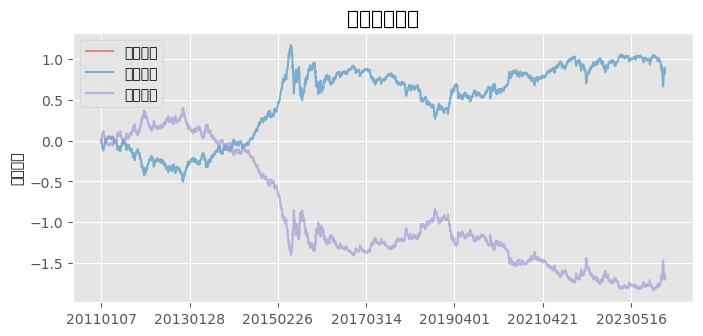

,指数收益,超额收益,策略收益
年化收益率,0.065,-0.129,NaN
年化波动率,0.254,0.251,NaN
夏普率,0.254,-0.512,NaN
最大回撤,-0.901,-2.226,NaN
收益回撤比,0.072,-0.058,NaN
胜率,0.549,0.451,0.0
盈亏比,0.861,1.109,NaN


(        指数收益   超额收益  策略收益
 年化收益率  0.065 -0.129   NaN
 年化波动率  0.254  0.251   NaN
 夏普率    0.254 -0.512   NaN
 最大回撤  -0.901 -2.226   NaN
 收益回撤比  0.072 -0.058   NaN
 胜率     0.549  0.451   0.0
 盈亏比    0.861  1.109   NaN,
            策略     index  策略收益      指数收益      超额收益
 20110107  NaN  1.000000   NaN  0.000000  0.000000
 20110110  NaN  0.975156   NaN -0.025158  0.024540
 20110111  NaN  0.969351   NaN -0.031129  0.030476
 20110112  NaN  0.975628   NaN -0.024673  0.023979
 20110113  NaN  0.975004   NaN -0.025314  0.024619
 ...       ...       ...   ...       ...       ...
 20240222  NaN  2.273208   NaN  0.821192 -1.631273
 20240223  NaN  2.334032   NaN  0.847597 -1.658395
 20240226  NaN  2.367792   NaN  0.861958 -1.672964
 20240227  NaN  2.431475   NaN  0.888498 -1.700228
 20240228  NaN  2.286058   NaN  0.826829 -1.642142
 
 [3192 rows x 5 columns],
 0,
 1,
 100,
 True,
 'all')

In [63]:
ff.run(factor*ff.filter0, positions = 100, period = 1, fees = 0) 

In [49]:
np.nansum(Cor_up_stock_volume,axis = 0)

array([ 0.        ,  0.        ,  0.        , ...,  0.34656111,
        0.        , 14.5004953 ])

In [83]:
Cor_up_stock_volume[100][-240:].sum()

0.22790991549183293

In [25]:
for i in range(5000):
    print(Cor_up_stock_volume[i][-240:].sum())

0.17267148475933958
0.16495038498953815
0.19004807247850605
nan
0.25495568071278146
0.07997252526211797
0.4247151624185351
0.16193300453113577
0.16547610917105532
0.3167581797101035
0.21273472203940944
0.2736519455121518
0.21884047474741947
0.2588186676894091
0.3133921093341741
0.22948799962091598
0.15672297121029474
0.0
0.2499190894748023
0.21099336384816564
0.2368316088133336
0.359326663762367
0.14557377937397442
0.2373461857521646
0.20806577498533022
0.18678017852500453
0.1905961822225352
0.2577229513052749
0.3070495706212111
0.23226088806702105
0.32988208874633945
0.15399340441183518
0.25414181955007237
0.1873376516621182
0.24192563092150268
0.17719829640067333
0.22860607729129548
0.23047370764997982
0.236112870503856
0.17915152659147754
0.3272357774587024
0.3186485507231632
0.3560120994364857
0.1732893314038922
0.1986255162029199
0.3066778177741044
0.15976787785522176
0.19556643768878468
0.1933769187846437
0.14867204535628428
0.21835606717990586
0.24700700805080436
0.1703123792930

In [41]:
data_mean.

(5246, 249840)